# Set of utilities to control the PSF determination on CFHT images

### Retrieve PSF objects from calexps for a set of images and for every CCD and compute a gaussian PSF width (FWHM)

In [35]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.meas.algorithms as measAlg
import lsst.afw.display.ds9 as ds9
import math

visits = [849375, 850587, 907254, 995367, 996234, 850181, 906675, 912206, 995974, 996717]
filter = 'r'

sigmaToFwhm = 2.0*math.sqrt(2.0*math.log(2.0)) 

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output")

psfHist = []

for cnts, visit in enumerate(visits) :
    tmp = []
    for ccd in range(36) :
        dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}

        # Retrieve calexp
        calexp = butler.get('calexp', dataid)

        x0 = calexp.getX0()
        y0 = calexp.getY0()
        width = calexp.getWidth()
        height = calexp.getHeight()
        wcs = calexp.getWcs()

        psf = calexp.getPsf()

# Display PSF
#image = psf.computeImage()
#print dir(image)
#ds9.mtv(image,frame=1)

        shape = psf.computeShape()

        attr = measAlg.PsfAttributes(psf, x0 + width // 2, y0 + height // 2)
        fwhm = attr.computeGaussianWidth() * wcs.pixelScale().asArcseconds() * sigmaToFwhm
        
        if fwhm < 0.1 :
            print visit, ccd, fwhm
        
        tmp.append(fwhm)
    psfHist.append(tmp)

### Plot results - 1 histogram / image - 1 entry / CCD

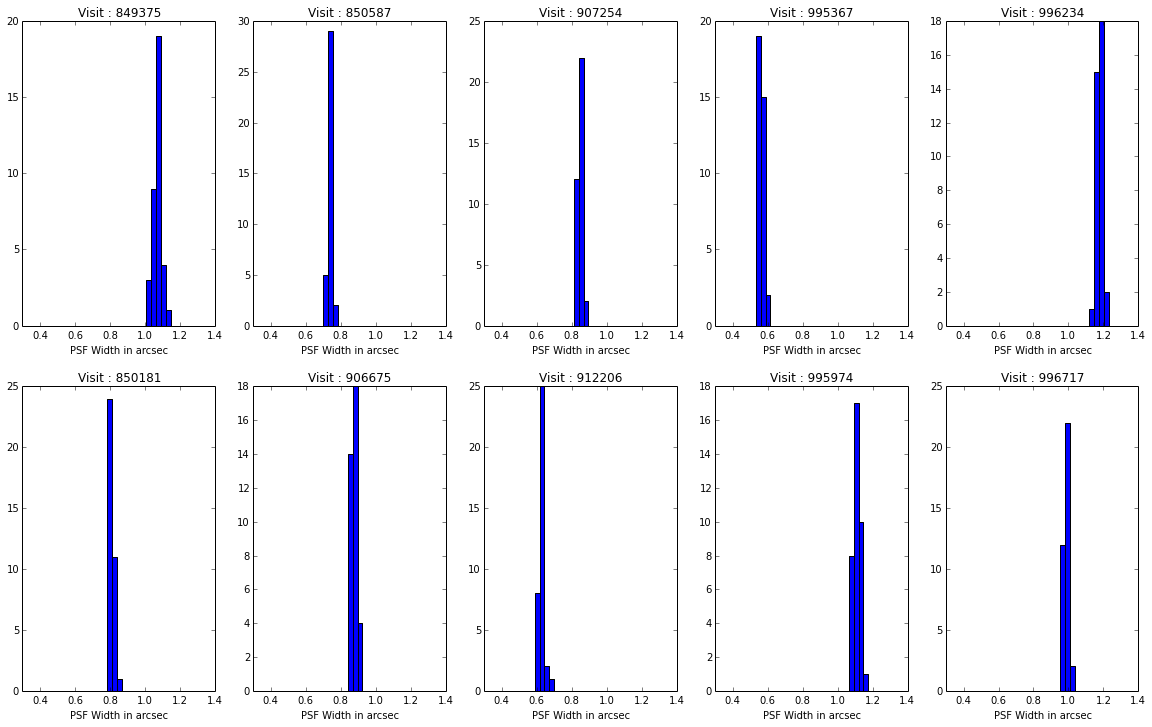

In [40]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

plt.clf()
fig, (ax0) = plt.subplots(nrows=2, ncols=5, figsize=(20,12))

rg = [0.,1.4]

for i in range(2) :
    for j in range(5) :
        ax0[i,j].hist(psfHist[i*5+j], bins=50, range=rg)
        ax0[i,j].set_xlim([0.3,1.4])
        ax0[i,j].set_xlabel("PSF Width in arcsec")
        tit = "Visit : " + str(visits[i*5+j])
        ax0[i,j].set_title(tit)
plt.show()


### Compute PSF width for every CCD of a given image and calculate distance between the center of the CCD to the center of the focal plane

In [18]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.meas.algorithms as measAlg
import lsst.obs.cfht as obs_cfht
from lsst.afw.cameraGeom import Camera
from lsst.afw.cameraGeom import PUPIL, FOCAL_PLANE
import lsst.afw.display.ds9 as ds9
import math

# Image identification keys
visit = 995367
filter = 'r'

sigmaToFwhm = 2.0*math.sqrt(2.0*math.log(2.0)) 

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output")

mapper = obs_cfht.MegacamMapper()
camera = mapper.camera

fwhmDist = []
distDist = []
for ccd in range(36) :

    dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}

    # Retrieve calexp
    calexp = butler.get('calexp', dataid)

    x0 = calexp.getX0()
    y0 = calexp.getY0()
    width = calexp.getWidth()
    height = calexp.getHeight()
    wcs = calexp.getWcs()

    psf = calexp.getPsf()
    
    # Display PSF
    #image = psf.computeImage()
    #print dir(image)
    #ds9.mtv(image,frame=1)
    
    shape = psf.computeShape()
    
    attr = measAlg.PsfAttributes(psf, x0 + width // 2, y0 + height // 2)
    fwhm = attr.computeGaussianWidth() * wcs.pixelScale().asArcseconds() * sigmaToFwhm
    fwhmDist.append(fwhm)
    
    ccdName = 'ccd'+str(ccd).zfill(2)
    ccdGeom = camera[ccdName]
    x = ccdGeom.getCenter(FOCAL_PLANE).getPoint().getX()
    y = ccdGeom.getCenter(FOCAL_PLANE).getPoint().getY()
    dist = math.sqrt(x*x+y*y)
    distDist.append(dist)
    
    print visit, ccd, fwhm, dist

995367 0 0.564114301899 151.590472829
995367 1 0.554516890577 131.369309671
995367 2 0.548671618041 114.779481999
995367 3 0.562179298038 103.554675941
995367 4 0.541946673569 99.501764653
995367 5 0.547808226791 103.470931421
995367 6 0.552435980155 114.67536063
995367 7 0.564273283429 131.241675467
995367 8 0.561583529918 151.469573612
995367 9 0.570465598316 118.64773537
995367 10 0.556214709427 91.3933521177
995367 11 0.542057009869 65.3296179123
995367 12 0.553393028129 42.6088942102
995367 13 0.558234178387 31.5428540015
995367 14 0.560766030959 42.4700586156
995367 15 0.551095732693 65.1995456181
995367 16 0.545647659249 91.2679561158
995367 17 0.548213803341 118.485339529
995367 18 0.580644198995 118.636984001
995367 19 0.575736217411 91.3874283699
995367 20 0.554023440379 65.3166082483
995367 21 0.555507272568 42.5398993542
995367 22 0.556820758251 31.4618542693
995367 23 0.565831463504 42.4654130742
995367 24 0.556315741183 65.1616573727
995367 25 0.547288829577 91.2374468711

### Plot results and compare to SNLS values provided by Pierre Astier for the same exposure

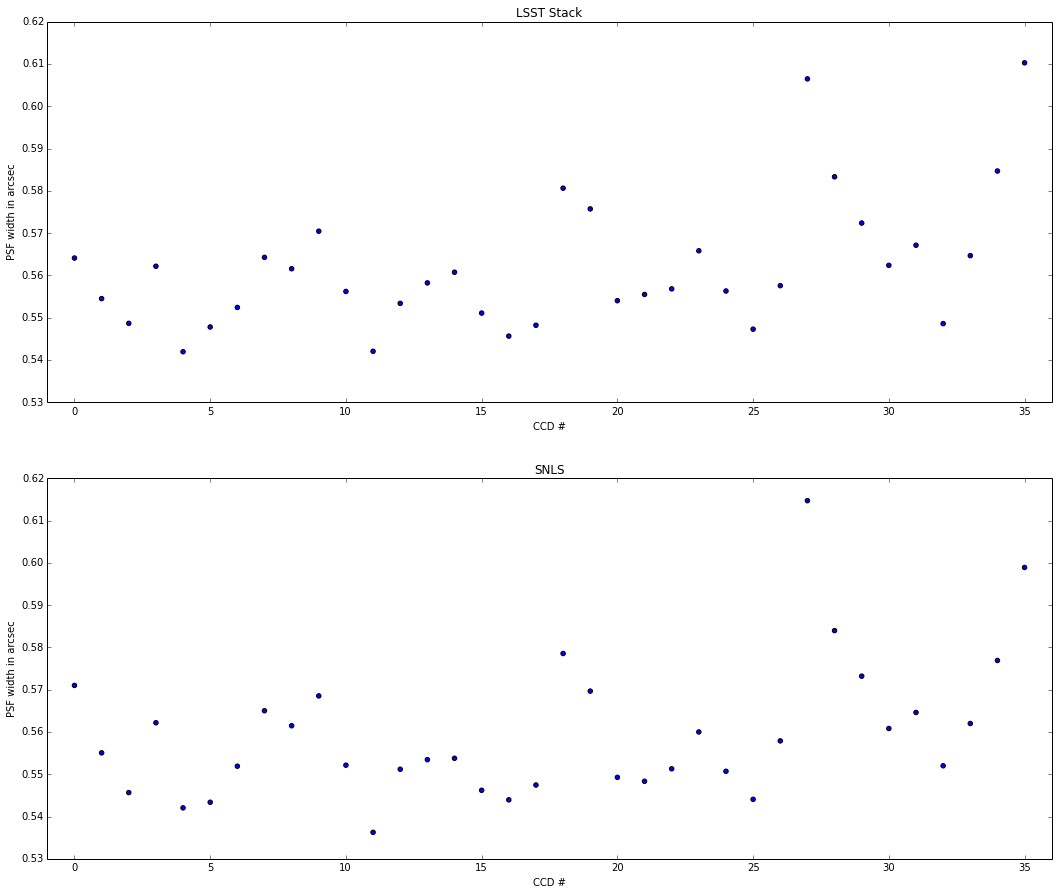

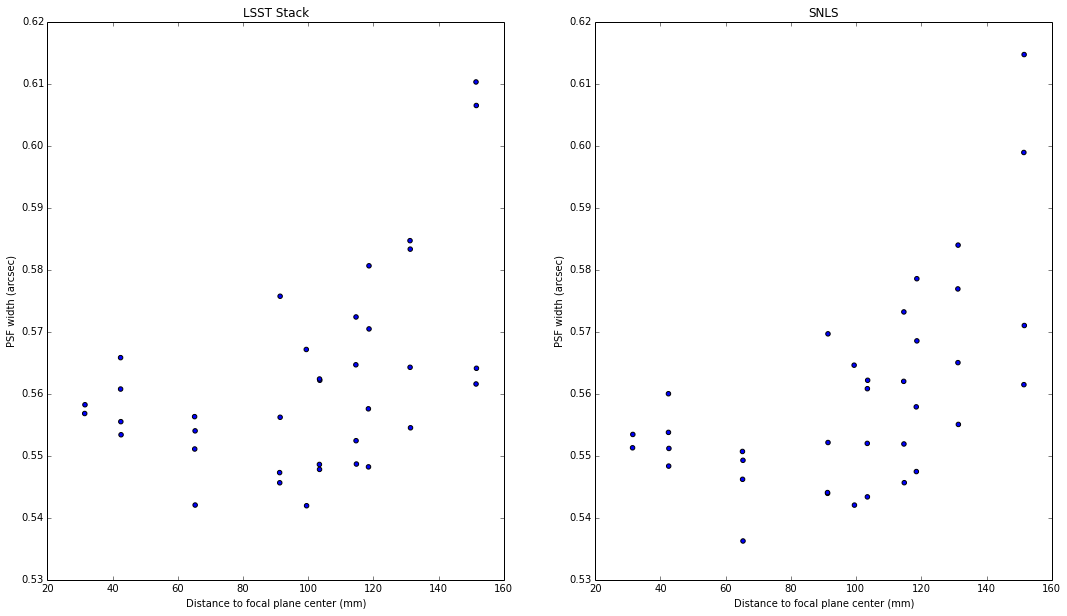

In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

fwhmPA = [0.571016,0.555061,0.545662,0.56218,0.542048,0.543374,0.551908,0.565028,0.561476,0.568536,0.552143,0.53626,
          0.551186,0.553445,0.553778,0.546209,0.543944,0.547457,0.578563,0.56967,0.549273,0.548339,0.551291,0.560009,
          0.550702,0.544072,0.557894,0.614717,0.583981,0.573206,0.560824,0.564616,0.552001,0.562008,0.576915,0.598922]

plt.clf()
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
ax0.scatter(range(36), fwhmDist)
ax0.set_xlim([-1.,36.])
ax0.set_xlabel("CCD #")
ax0.set_ylabel("PSF width in arcsec")
ax0.set_title("LSST Stack")
ax1.scatter(range(36), fwhmPA)
ax1.set_xlim([-1.,36.])
ax1.set_xlabel("CCD #")
ax1.set_ylabel("PSF width in arcsec")
ax1.set_title("SNLS")

fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(18,10))
ax3.scatter(distDist,fwhmDist)
ax3.set_xlabel("Distance to focal plane center (mm)")
ax3.set_ylabel("PSF width (arcsec)")
ax3.set_title("LSST Stack")
ax4.scatter(distDist,fwhmPA)
ax4.set_xlabel("Distance to focal plane center (mm)")
ax4.set_ylabel("PSF width (arcsec)")
ax4.set_title("SNLS")

In [ ]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.meas.algorithms as measAlg
import math

filter = 'r'

# Select a chip close to the center of the focal plane
ccd = 13

sigmaToFwhm = 2.0*math.sqrt(2.0*math.log(2.0)) 

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output")

filename = "../utils/stage/obs_D3_r.list"
file = open(filename, "r")

psfHist = []

for visit in file :

    dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}

    # Retrieve calexp
    calexp = butler.get('calexp', dataid)

    x0 = calexp.getX0()
    y0 = calexp.getY0()
    width = calexp.getWidth()
    height = calexp.getHeight()
    wcs = calexp.getWcs()

    psf = calexp.getPsf()
    shape = psf.computeShape()

    attr = measAlg.PsfAttributes(psf, x0 + width // 2, y0 + height // 2)
    fwhm = attr.computeGaussianWidth() * wcs.pixelScale().asArcseconds() * sigmaToFwhm
        
    if fwhm < 0.1 :
        print visit, ccd, fwhm
    
    psfHist.append(fwhm)

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

plt.clf()
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
ax0.hist(fwhmDist)